### 1. Sekcja odczytywania danych, określania typów danych cech.

In [126]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score


target_var: str = "CO2 Emissions(g/km)" #To jest nazwa zmiennej docelowej.
target_var_discr: str = "CO2 Emissions(g/km)_disc" #To jest nazwa zmiennej docelowej, która została poddana proceowi dyskretyzacji.

dtypes = { "Make": "category", #Określ typ danych każdej cechy w ramce danych, która zostanie zaraz odczytana.
            "Model":"category",
            "Vehicle Class":"category",
            "Engine Size(L)":np.float64,
            "Cylinders":"category",
            "Transmission":"category",
            "Fuel Type":"category",
            "Fuel Consumption City (L/100 km)":np.float64,
            "Fuel Consumption Hwy (L/100 km)":np.float64,
            "Fuel Consumption Comb (L/100 km)":np.float64,
            "Fuel Consumption Comb (mpg)":np.float64,
            "CO2 Emissions(g/km)":np.float64}



def ReadDataFrame(filename:str, sep:str =';', dec_sep:str =',') -> tuple[pd.DataFrame, int]:
    """Odczytuje plik o nazwie filename i wprowadza dane z pliku do ramki danych."""
    global dtypes
   
    Dataset = pd.read_csv(filename,
                        sep=sep, dtype = dtypes, decimal = dec_sep) #Wczytaj plik z danymi.

    n_rows:int  = Dataset.shape[0] #Liczba wszystkich wierszy w ramce danych

    return Dataset, n_rows



Dataset, n_rows = ReadDataFrame("CO2Emission.csv")

n_splits = 5
train_size = 0.8
test_size  = 1 - train_size




### 2. Sekcja statystyki opisowej zmiennych kategorycznych

### Częstość występowania  unikatowych klas dla danej zmiennej.

In [141]:
def CreateHistogram(Dataset:pd.DataFrame, CatFeature:str) ->  pd.DataFrame:
    """Funkcja dla każdej unikatowej klasy z cechy CatFeature wylicza liczbę jej wystapień.
    Wynikiem funkcji jest pandowska ramka danych, która zawiera trzy kolumny o nazwach odpowiednio: 'CatFeature', 'CatFeature_coded' oraz 'count'.
    Kolumna CatFeature_coded zawiera zakodowane nazwy klas w postaci liczb całkowitych. Taka forma ułatwia odczytywanie etykiet na wykresach.
    """

    Histogram:pd.DataFrame = Dataset[CatFeature].value_counts(sort = True,) #Stwórz proste podsumowanie częstotliwości występowania klas.

    return  Histogram

def PlotHistogram(Histogram:pd.Series, CatFeature:str, Showxlabels:bool = False) -> None:
    """Funkcja rysuje histogram na bazie tabelki histogramowej. 
    1) Histogram  - Histogram kategorii danej zmiennej kategorycznej
    2) CatFeature  - Cecha kategoryczna, której histogram chcemy narysować."""
    
    plt.figure(figsize = (10,5)) #Stwórz płótno, na którym  będzie rysowany wykres
 
    axes = sns.barplot(x = Histogram.index, y = Histogram.values)


    axes.set_ylabel(f"Częstość klasy") #Ustaw etykietke pionowej osi.

    axes.set_xticklabels([]) #Usuń etykiety tyknięć na osi Ox.
    axes.spines[["top", "right"]].set_visible(False)

    axes.set_title(f"Histogram klas cechy {CatFeature}") #Ustaw tytuł wykresu.

    axes.set_ylim(0, 1.05*np.max(Histogram))

    if Showxlabels == True:
        axes.set_xticklabels(labels = Histogram.index)
        



def AggregateRarestClasses(Dataset:pd.DataFrame, CatFeature:str, Histogram:pd.Series, q_degree:float = 0.15) -> None:
    """Klasy, które występują rzadziej niż wartość wskaźnika threshold_frequent, dostaną etykietę "Other". Etykietki pozostałych klas nie ulegną zmian.
    1) Dataset - oryginalny zestaw danych.
    2) CatFeature - Zmienna kategoryczna, której rzadkie klasy chcemy zagregować.
    3) Histogram - Histogram cechy CatFeature
    4) q_degree  - stopień kwantylu. 
    Funkcja jedynie modyfikuje zestaw danych, dlatego właśnie nie zwraca żadnej wartości."""
    frequent_threshold:float = Histogram.quantile(q = q_degree)

    Dataset[CatFeature] = Dataset[CatFeature].apply(func = lambda categ: "Other" if Histogram[categ] < frequent_threshold else categ)






Pierwsze wnioski, jakie można wysunąć:


### Zmienna make może zostać skasowana. Nie jest ona dobrą zmienną, którą można uwzględnić w modela, z powodu ogromnej liczby unikatowych klas (ponad 2000), co czyni ją niemalże zmienną identyfikującą.

### Obserwacja, której typ paliwa to 3, może zostać pominięta. Występuje nienormalnie rzadko.

### Kasujemy zmienną Model oraz obserwację, której cecha "Fuel Type" wynosi N

In [142]:
def DeleteFutileColsAndObs(Dataset:pd.DataFrame) -> pd.DataFrame:

    Dataset.drop(columns = ["Model"], inplace = True)

    Dataset = Dataset.query('`Fuel Type` != "N"')

    return Dataset
    

### 3. Cechy numeryczne ciągłe.

### Badanie zależności poziomu emisji dwutlenku węgla w zależności od wielkości spalania paliwa na autostradzie i w mieście dla różnych typów paliwa.
### Dodatkowo zbadamy współczynniki korelacji między tymi cechami ciągłymi.



In [143]:
def ComputeAndDrawCorrelationMatrix(Dataset:pd.DataFrame, FloatFeatures: list[str]) -> None:
    """Funkcja wylicza macierz korelaji dla zmiennych z listy FloatFeatures. Ponadto, rysuje tę macierz korelacji na wykresie, aby można
    było sobie uzmysłowić relacje między zmiennymi
    1) Dataset - oryginalny zbiór danych
    2) FloatFeatures  - zmienne ciągłe"""
    CorrMatrix:pd.DataFrame =  Dataset[FloatFeatures].corr(method = "pearson")

    plt.figure(figsize=(8, 6))

    sns.heatmap(CorrMatrix, annot=True, cmap='magma', vmin=-1, vmax=1)
    plt.title('Macierz korelacji dla zmiennych ciągłych')
    plt.show()



### 4. Dyskretyzacja zmiennej docelowej.

In [144]:
def Discretize(Dataset:pd.DataFrame, target_var:str, bins:list[float]) -> None:
    labels = [i for i in range(len(bins)+1)]
    bins = [-float("inf")] + bins + [float('inf')]


    discretized_feature = pd.cut(x = Dataset[target_var], 
                                 bins = bins, 
                                 labels = labels)

    Dataset[target_var_discr] = discretized_feature


### 6. Wykresy gęstości prawdopodobieństwa, pudełkowe oraz skrzypcowe dla zmiennych ciągłych.

In [164]:
def NarysujGęstości(Dataset:pd.DataFrame, FloatFeatures:list[str]) -> None:
    """Ta funkcja rysuje wykresy gęstości prawdopodobieństwa dla zmiennych ciągłych.
    1) Dataset - oryginalny zestaw danych.
    2) FloatFeatures - zmienne numeryczne"""

    for floatFeature in FloatFeatures:
        figure = plt.figure(num = f"KDE_plot_{floatFeature}")
        axes = figure.add_subplot()

        sns.kdeplot(data = Dataset, x = floatFeature, ax = axes)
        axes.set_title(f"Wykres gęstości prawdopodobieństwa dla zmiennej {floatFeature}")


def NarysujPudełko(Dataset:pd.DataFrame, FloatFeatures:list[str]) -> None:
    """Ta funkcja rysuje wykresy pudełkowe dla zmiennych ciągłych.
    1) Dataset - oryginalny zestaw danych.
    2) FloatFeatures - zmienne numeryczne"""

    for floatFeature in FloatFeatures:
        figure = plt.figure(num = f"BOX_plot_{floatFeature}")
        axes = figure.add_subplot()

        sns.boxplot(Dataset, x = floatFeature)

        axes.set_title(f"Wykres pudełkowy dla zmiennej {floatFeature}")


def NarysujSkrzypce(Dataset:pd.DataFrame, FloatFeatures:list[str], Condition:str | None = None) -> None:
     """Ta funkcja rysuje wykresy skrzypcowe dla zmiennych ciągłych.
    1) Dataset - oryginalny zestaw danych.
    2) FloatFeatures - zmienne numeryczne
    3) Condition = Pewna zmienna kategoryczna, za pomocą której stworzą się warunkowe wykresy skrzypcowe ze względu przynależność do klasy."""

     for floatFeature in FloatFeatures:
        figure = plt.figure(num = f"VIOLIN_plot_{floatFeature}")
        axes = figure.add_subplot()

        sns.violinplot(Dataset, x = floatFeature, hue = Condition)

        axes.set_title(f"Wykres skrzypcowy dla zmiennej {floatFeature}")

        axes.legend([])

        axes.grid(True, alpha = 0.6)
        axes.spines[['top','right']].set_visible(False)



def NarysujWykresParowy(Dataset:pd.DataFrame, FloatFeatures:list[str], Condition: str | None = None) -> None:
    """Funkcja rysuje wykres parowy dla wszystkich par zmiennych ciągłych.
    """
    sns.pairplot(Dataset[FloatFeatures], 
    hue = Condition,
    diag_kind = "kde")

    



In [132]:
Predictors = ['Make', "Vehicle Class",'Engine Size(L)','Cylinders','Transmission','Fuel Type',"Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)",
                                                                                   "Fuel Consumption Comb (L/100 km)","Fuel Consumption Comb (mpg)"]

num_predictors = [feature for feature in Predictors if dtypes[feature] is np.float64]
cat_predictors = [feature for feature in Predictors if dtypes[feature] == "category"]

### 8. Kodowanie zmiennych kategorycznych.

In [133]:
def ZakodujDane(Dataset:pd.DataFrame, CatFeatures:list[str], NumFeatures:list[str]) -> pd.DataFrame:
    """Funkcja koduje  zmienne niezależne kategoryczne za pomocą transformatora OHE."""
    cat_col_transformer = ColumnTransformer(transformers = 
                                            [('OHE',OneHotEncoder(sparse_output = False), CatFeatures)],
                                            remainder = "passthrough",)
    
    #Przekształć zmienną X za pomocą określonego wyżej transformatora. 
    X_coded = cat_col_transformer.fit_transform(X = Dataset)
    
    CatFeatures_coded = cat_col_transformer.named_transformers_["OHE"].get_feature_names_out(input_features = CatFeatures,)

    Dataset_coded = pd.DataFrame(data = X_coded, columns =  np.concatenate((CatFeatures_coded, NumFeatures)))
    
    return Dataset_coded



def TransformujDane(X: pd.DataFrame,  numpredictors:list[str], pca_predictors:list[str]) -> tuple[ np.ndarray, ColumnTransformer]:
    """Funkcja stosuje standaryzacje dla tablicy, która zawiera już zmienne będące liczbami.
    Numpredictors to zmienne, które zostaną poddane procesowi standaryzacji. pca_predictors to cechy, dla których składowe główne zostaną wyliczone"""
    col_transformer = ColumnTransformer(transformers = [("Scaler", StandardScaler(), numpredictors) ,
                                                             ('PCA', PCA(n_components = 1), pca_predictors)], remainder = "passthrough")


    return col_transformer.fit_transform(X = X),  col_transformer



### Definiowanie modeli, list na ich wyniki, na hiperparametry modeli.

In [134]:
from sklearn.linear_model import LogisticRegression

# Definicja modeli z hiperparametrami
Models = {
    "DrzewkoDecyzyjne": DecisionTreeClassifier(criterion="gini", splitter="best", min_samples_split=10), 
    "LasLosowy": RandomForestClassifier(n_estimators=15, criterion='gini'), 
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "RegresjaLiniowa": MultiOutputRegressor(estimator = LinearRegression()),
    "RegresjaLogistyczna": LogisticRegression()
}                


#Słownik do przechowywania hiperparametrów modeli:
Models_hipparams = {"DrzewkoDecyzyjne":{"criterion":['gini','entropy'],
                                        "splitter":['best','random'],
                                        "min_samples_split":[3,5],
                                        "min_samples_leaf":[2,3]},

                    "LasLosowy":{"n_estimators":list(range(10, 50, 5)),
                                  "criterion":['gini','entropy'],
                                        "min_samples_split":[3,5],
                                         "min_samples_leaf":[2,3]},
                                        
                    "KNN": {"n_neighbors":list(range(1, 10, 2)),
                            "p":[1,2]},
                        "RegresjaLogistyczna": {
                            "penalty":['l1','l2'],
                             "solver":['lbfgs','liblinear','newton-cg',],
                             'multi_class':['auto','ovr','multinomial']
                        }
                            }



def TrainAndTestModelStat(Model, X_train:pd.DataFrame, y_train:pd.DataFrame, X_test:pd.DataFrame) -> np.ndarray:
    """Funkcja trenuje model za pomocą danyc treningowych (X_train, y_train), a następnie dokonuje predyckcji etykiet klasy docelowej i zwraca przewidywane etykietki.
    Jeżeli model jest regresją liniową, przewidziane etykietki są tablicą wymiaru (n_test, n_outputs), gdzie n_outputs to liczba klas emisji.
    W przeciwnym wypadku  etykietki są wymiaru (n_test, 1)"""
    Model.fit(X = X_train, #Znajdź optymalne parametry dla danego Modelu, eksponując model na dane treningowe.
              y = y_train) \

    return Model.predict(X_test) # Dokonaj przewidywań etykietki klas. Nie zwracamy od razu metryki dokładności. Przewidziane etykietki pomogą nam metrykę policzyć oraz ułatwią
                                 #stworzenie macierzy pomyłek. \


def StworzTabelkePorównawczą() -> pd.DataFrame:
    global Models, n_splits
    """Funkcja stwarza tabelkę porównawcza, która jest po prostu ramką pandas. Indeksy kolumn są trzypoziomowe. Na najwyższym poziomie jest nazwa modelu, niżej jest
    numer podziału, a na końcu tyb etykiet (prawdziwe etykiety lub prawdziwe etykiety)"""


    Indeces = pd.MultiIndex.from_product( [list(Models.keys()), range(n_splits), ["True", "Pred"] ] #Stwórz  hierarchiczny system indeksów dla kolumn.
                                        ,names = ["Model", "iter_no", "array_type"]) #Nadaj poszczególnym poziomom wyjaśnialne i sensowne nazwy.

    return  pd.DataFrame(data = None, 
                                    columns = Indeces)


def ComputeAccuracy(TruevsPrediction:pd.DataFrame) -> pd.DataFrame:
    """Funkcja, na podstawie tabeli porównań etykiet prawdziwych i przewidywanych, oblicza pewną miarę dokładności (accuracy_score) dla wszystkich modeli i dla wszystkich  powtórzeń."""

    MetricComparison = np.zeros(shape = [n_splits, len(Models.keys())], 
                                 dtype = np.float64)
    
    
    for model_indx, model in enumerate(Models.keys()):
        for i in range(n_splits):
            y_true = TruevsPrediction[(model, i, "True")]
            y_pred = TruevsPrediction[(model, i, "Pred")]

            perfomance_metric = accuracy_score(y_true = y_true, 
                                               y_pred = y_pred)

            MetricComparison[i, model_indx] = perfomance_metric

    return pd.DataFrame(data = MetricComparison, 
                                     columns = list(Models.keys()))



def ComputeMetric(TruevsPrediction:pd.DataFrame, metric) -> pd.DataFrame:
    """Funkcja wylicza precyzje albo wrażliwość albo f1"""
    MetricComparison = np.zeros(shape = [n_splits, len(Models.keys())], 
                                 dtype = np.float64)
    
    for model_indx, model in enumerate(Models.keys()):
        for i in range(n_splits):
            y_true = TruevsPrediction[(model, i, "True")]
            y_pred = TruevsPrediction[(model, i, "Pred")]

            perfomance_metric =  metric(y_true =y_true,
                                                  y_pred = y_pred, 
                                                  average = "weighted",)

            MetricComparison[i, model_indx] = perfomance_metric


    return pd.DataFrame(data = MetricComparison, 
                                     columns = list(Models.keys()))



In [135]:
def PlotlineScores(perfomance_df: pd.DataFrame, metric_name:"str", n_splits:int, params_type:str = "statyczna") -> None:
    """Stwórz wykresy liniowe obrazujące dynamikę zmian dokładności modeli."""
    figure = plt.figure()
    axes = figure.add_subplot()
    
    x_values = list(range(0,n_splits))
    
    for model_name in Models.keys():
        axes.plot(x_values, perfomance_df[model_name], linestyle = "--")

    axes.legend(list(Models.keys()))
    axes.set_title(f"Dynamika zmian metryki {metric_name} dla modeli, wersja {params_type}")

    axes.set_xlabel("Numer iteracji") #Ustaw ładną etykietkę osi Ox
    axes.set_ylabel(f"{metric_name}") #Ustaw ładną etykietkę osi Oy

    axes.set_xticks(x_values) #Ustaw wartości tyknięć na osi Ox
    
    axes.grid(True) #Dodaj linie siatki


    axes.spines[['top','right']].set_visible(False) #Usuń kreskę górną oraz dolną.

def PlotConfussionMatrices(model_name:str, y_true:np.ndarray, y_predicted: np.ndarray, type:str = "stat"):
    """Funkcja ta rysuje macierz pomyłek dla  danego modelu. 
        1) y_true  są etykietkami rzeczywistymi
        2) y_predicted są etykietkami przewidzianymi
        3) type jest to typ strojenia parametrów. Może być ten tryb statyczny (wtedy piszemy type = "stat") albo dynamiczny (wtedy piszmey type = "dyna")
        """
    axes = plt.figure(num = f"{model_name}_conf_matrix_{type}").add_subplot()


    cos = ConfusionMatrixDisplay.from_predictions(y_true = y_true, y_pred = y_predicted, ax = axes)
    axes.set_title(f"ConfMatrix dla  modelu {model_name}, wersja {type}")



def MacierzPomylek(TrueVSPrediction:pd.DataFrame, n_splits:int, type:str = "stat"):
    """Funkcja wylicza macierze pomyłek dla wszystkich modeli, a następnie obrazuje te macierze na wykresie.
    1) TrueVSPrediction: macierz zawierająca etykietki przewidywane oraz rzeczywiste
    2) Liczba podziałów zbioru dataset na zbiór treningowy i testowy.
    3) type = rodzaj strojenia parametrów (statyczny albo dynamiczny)"""

    for model_name in Models.keys():
        y_true = TrueVSPrediction[(model_name, 0, "True")] #Znajdź kolumnę prawdziwcych etykiet.
        y_pred = TrueVSPrediction[(model_name, 0, "Pred")] #Znajdź kolumne przewidywanych etykiet.
        
        PlotConfussionMatrices(model_name, y_true, y_pred, type) #Narysuj macierz pomyłek.




### Przygotowanie metody porównaczej.


c:\Users\pawel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\pawel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\pawel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\pawel\AppData\Local\Programs\Python\Python3

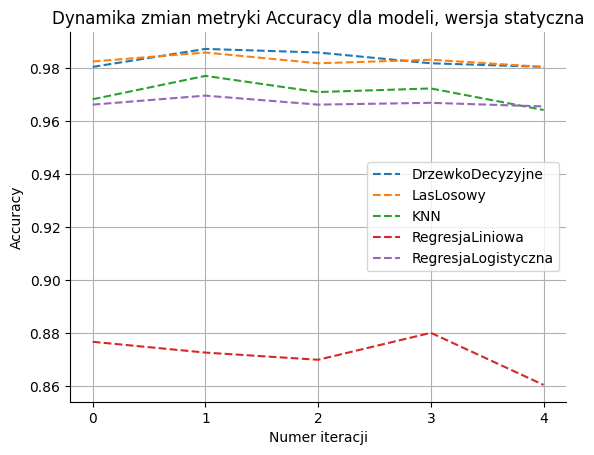

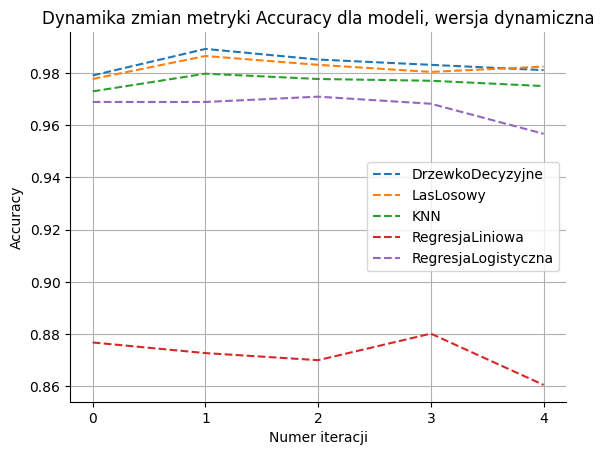

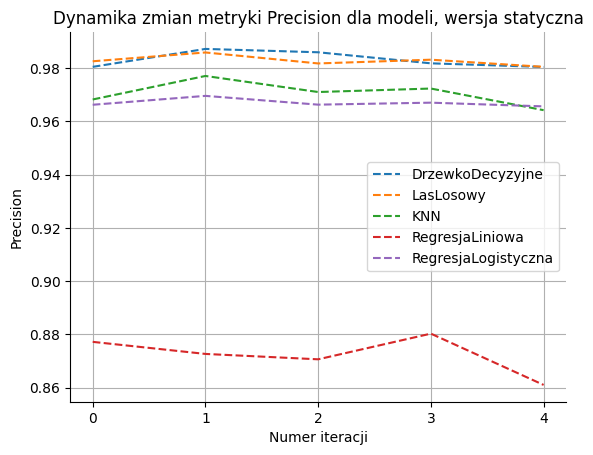

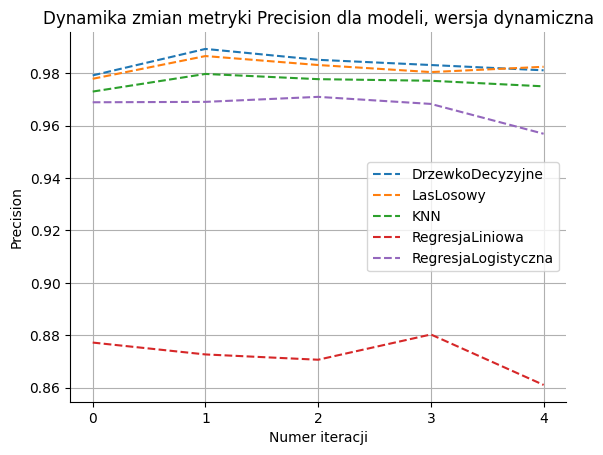

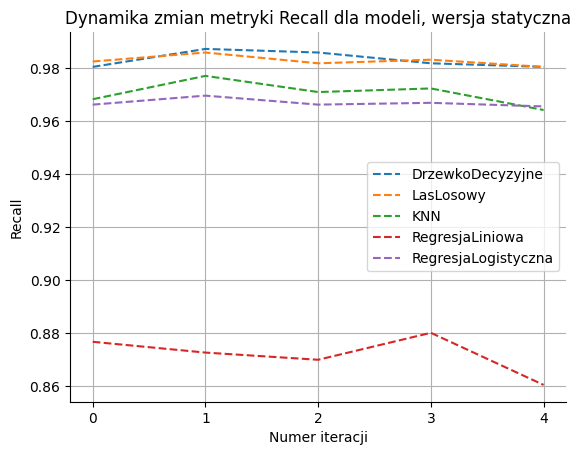

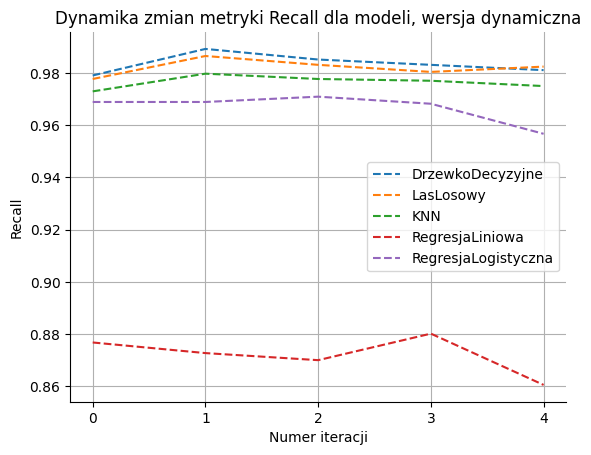

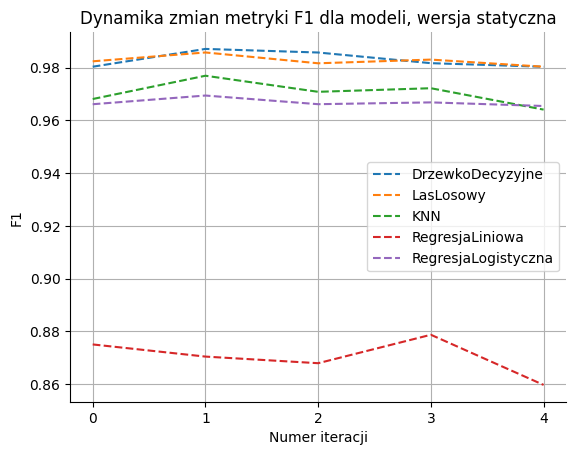

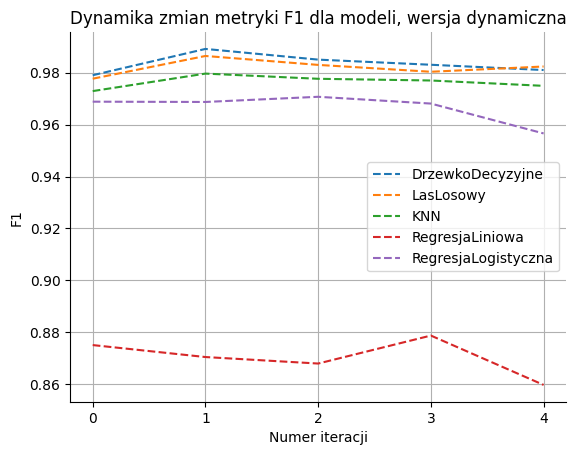

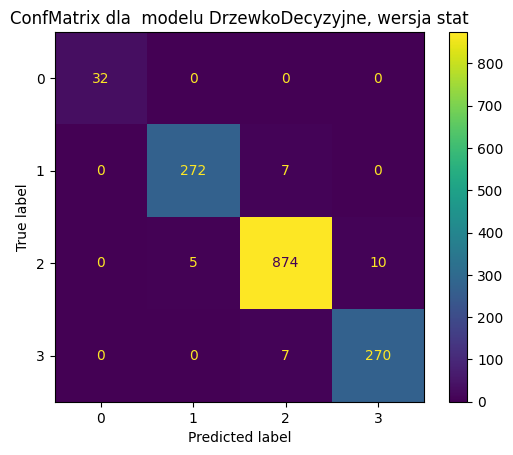

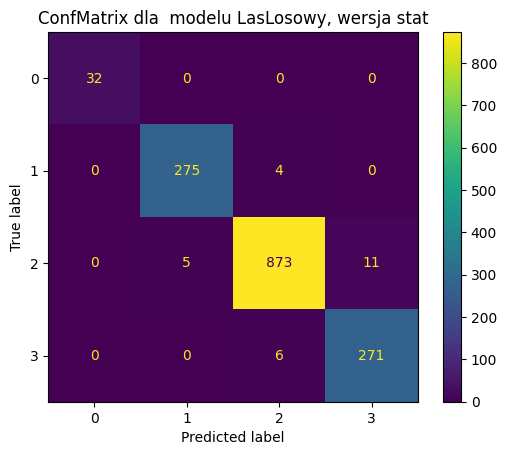

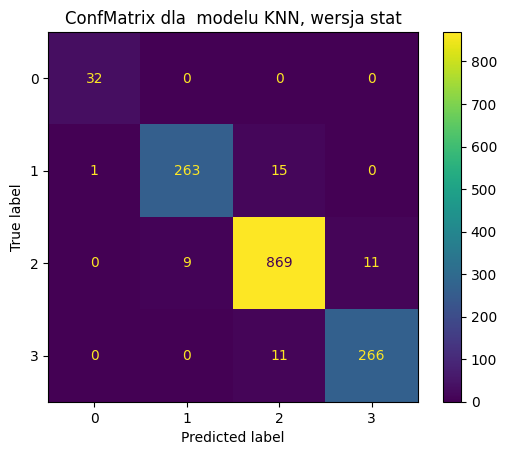

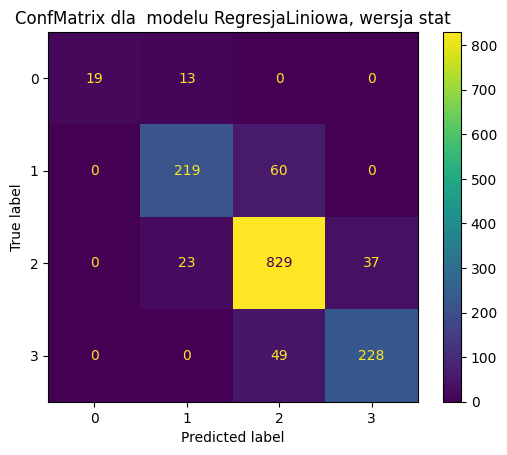

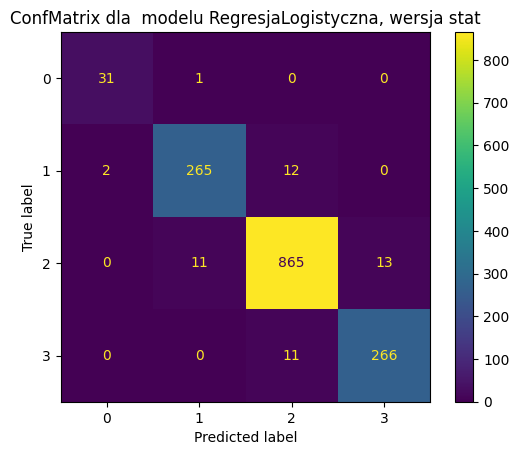

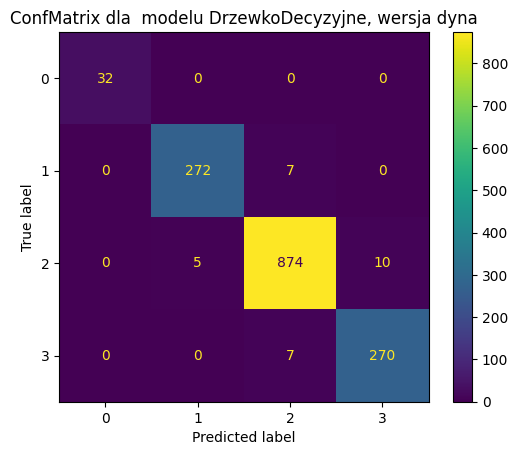

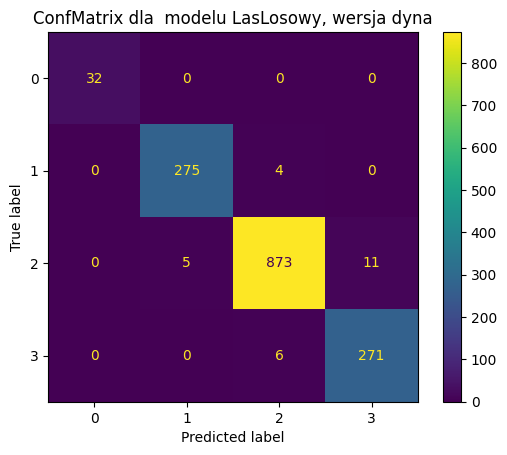

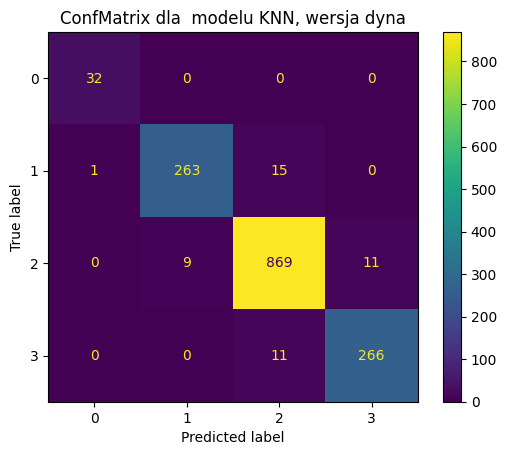

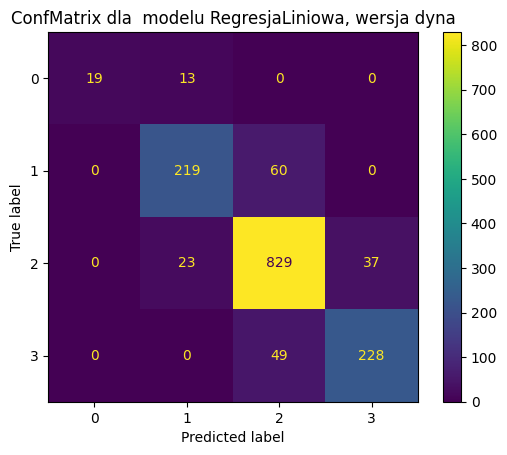

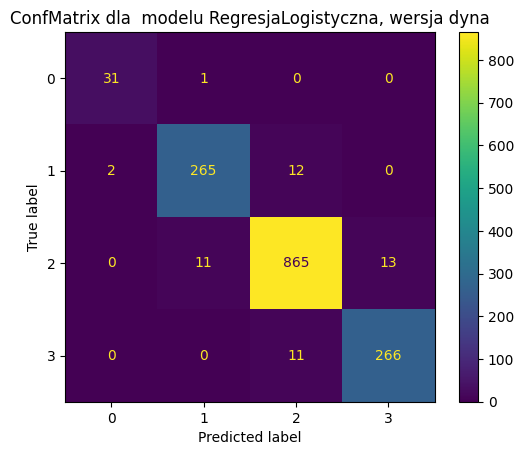

In [136]:
def TrenujITestujModele(Dataset:pd.DataFrame,CatPredictors:list[str], NumPredictors:list[str], 
                        Models:dict[str, "estimator"], Models_hipparams:dict[str,  dict[ str, list[ str | int | float] ] ],
                       n_splits:int = 5, train_size:float = 0.8, test_size:float =  0.2, 
                       com_type:str = "Stat") -> tuple[pd.DataFrame, pd.DataFrame]:
    TrueVSPrediction_stat = StworzTabelkePorównawczą()
    TrueVSPrediction_dyna = StworzTabelkePorównawczą()

    X = Dataset[CatPredictors + NumPredictors] #Zainicjuj ostateczny zbiór predyktorów.
    y = Dataset[[target_var_discr]] #Zdefiniuj zmienną celu (jest to wieloklasowa zmienna kategoryczna)

    X_coded = ZakodujDane(X, CatPredictors, NumPredictors) #Zakoduj zmienne kategoryczne predykcyjne.

    SSS = StratifiedShuffleSplit(n_splits = n_splits,  #Zdefiniuj stratyfikowany podział szufladkowy.
                                 train_size =train_size, 
                                 test_size = test_size)
    
    
    y_OHE = OneHotEncoder(sparse_output = False).fit_transform(X = y) #Zakoduj zmienną docelową jako zbiór k kolumn binarnych. 
                                                                        #Tak zakodowana etykietka przyda się w wielowyjściowej regresji.
    

    for iter_indx, indx in enumerate(SSS.split(X, y)): #Wydobadź indeksy treningowe i testowe.
        train_indx, test_indx = indx #Znajdź indeksy treningowe oraz indeksy testowe.
        
        X_train =  X_coded.iloc[train_indx, ]
        X_test = X_coded.iloc[test_indx, ]
    
    
        X_train ,Scaler = TransformujDane(X_train, NumPredictors, pca_predictors= ["Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)",
                                                                                   "Fuel Consumption Comb (L/100 km)","Fuel Consumption Comb (mpg)"])
        X_test = Scaler.transform(X_test) #Dokonaj skalowania na zbiorze testowym za pomocą parametrów wydobytych ze zbioru treningowego.

    
        for model_name in Models.keys():
            model:'Estimator' = Models[model_name] #Zrekrutuj model.

            if model_name != "RegresjaLiniowa":
                y_train = np.array(y.iloc[train_indx, :]).ravel()
                y_test =  np.array(y.iloc[test_indx, :]).ravel()

                

                #Statyczne dobieranie hiperparametrów.
                y_pred_stat: np.ndarray = TrainAndTestModelStat(model, X_train, y_train, X_test) #Etykietki przewidziane.


                #Miejsce na dynamiczne strojenie parametrów.
                model_hiperparams = Models_hipparams[model_name] #Wydobądź siatek hiperparametrów do przeszukania.
                    
                GridSearch = GridSearchCV(estimator = model, param_grid = model_hiperparams)
                fitted_model = GridSearch.fit(X = X_train, y = y_train) #To jest instancja modelu z najbardziej optymalnymi hiperparametrami.

                y_pred_dyna:np.ndarray = fitted_model.predict(X_test)


                #Doklej etykietki przewidziane do ramki danych porównującej statycznie-strojone modele.
                TrueVSPrediction_stat[(model_name, iter_indx, "True")] = y_test
                TrueVSPrediction_stat[(model_name, iter_indx, "Pred")] = y_pred_stat


                #Doklej etykietki przewidziane do ramki danych porównującej dynamicznie-strojone modele.
                TrueVSPrediction_dyna[(model_name, iter_indx, "True")] = y_test
                TrueVSPrediction_dyna[(model_name, iter_indx, "Pred")] = y_pred_dyna


            else:
                #Regresja liniowa niestety ma wielowymiarowe-wyjście.
                y_train = y_OHE[train_indx] #Weź etykietki docelowe treningowe.
                y_test = y_OHE[test_indx].argmax(axis = 1) #Weź etykietki docelowe testowe.


                y_pred: np.ndarray = TrainAndTestModelStat(model, X_train, y_train, X_test).argmax(axis = 1)
                

                #Doklej etykietki przewidziane do ramki danych porównującej statycznie-strojone modele.
                TrueVSPrediction_stat[(model_name, iter_indx, "True")] = y_test
                TrueVSPrediction_stat[(model_name, iter_indx, "Pred")] = y_pred


                #Doklej etykietki przewidziane do ramki danych porównującej dynamicznie-strojone modele.
                TrueVSPrediction_dyna[(model_name, iter_indx, "True")] = y_test
                TrueVSPrediction_dyna[(model_name, iter_indx, "Pred")] = y_pred



                        
    return TrueVSPrediction_stat, TrueVSPrediction_dyna



def PorównajModele(TrueVSPrediction_df_stat:pd.DataFrame,TrueVSPrediction_df_dyna:pd.DataFrame, n_splits:int ) -> None:
    """Funkcja wylicza miary dokładności dla wszystkich modeli. 
    Pierwsze dwa argumenty są ramkami danych, których wartościami są prawdziwe lub przewidziane etykietki. 
    Każda z tych ramek ma wielopoziomy system indeksowania kolumn, który jest postaci: (model_name, iter_indx, type).
    model_name jest nazwą danego modelu. iter_indx wskazuje na to, w którym podziale etykietki są przewidziane. type = "True" albo type = "Pred". 
    Gdy type = "True", etykietki są rzeczywiste, w przeciwnym wypadku są przewidziane."""


    Miary = {"Accuracy" : ComputeAccuracy, "Precision":ComputePrecision,
             "Recall":ComputeRecall, "F1": ComputeF1}
    

    for miara in Miary.keys():
        Metric_comparison_stat = Miary[miara](TrueVSPrediction_df_stat)
        Metric_comparison_dyna = Miary[miara](TrueVSPrediction_df_dyna)

        PlotlineScores(Metric_comparison_stat, miara, n_splits, "statyczna")
        PlotlineScores(Metric_comparison_dyna, miara, n_splits, "dynamiczna")


    MacierzPomylek(TrueVSPrediction_df_stat, n_splits) #Wylicz oraz narysuj macierz pomyłek dla statycznego strojenia hiperparametrów
    MacierzPomylek(TrueVSPrediction_df_stat, n_splits, type = "dyna") #Wylicz oraz narysuj macierz pomyłek dla dynamicznego strojenia hiperparametrów.



TrueVSPrediction_stat, TrueVSPrediction_dyna = TrenujITestujModele(Dataset,cat_predictors, num_predictors, Models, Models_hipparams, n_splits = n_splits) #Trenuj modele na różnych podziałach zbioru treningowego i testowego.

PorównajModele(TrueVSPrediction_stat, TrueVSPrediction_dyna, n_splits)




RYSOWANIE WYKRESÓW SKRZYPCOWYCH DLA Z MIENNYCH NUMERYCZNYCH
Rysowanie wykresu parowego dla zmiennych numerycznych
Dyskretyzacja zmiennej docelowej


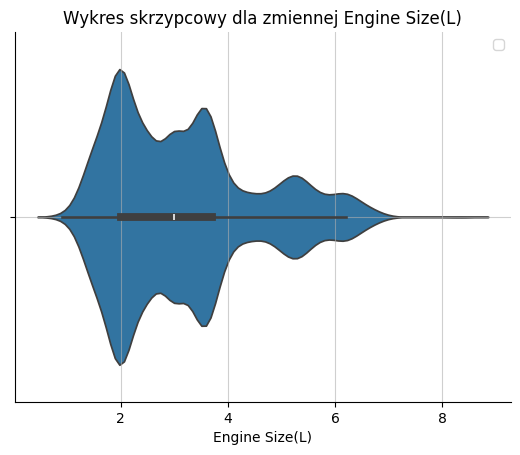

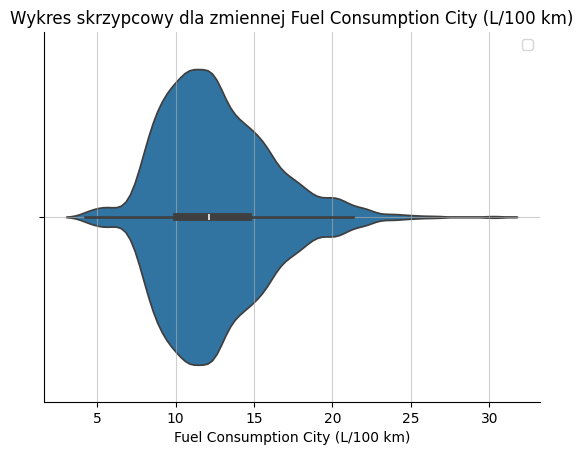

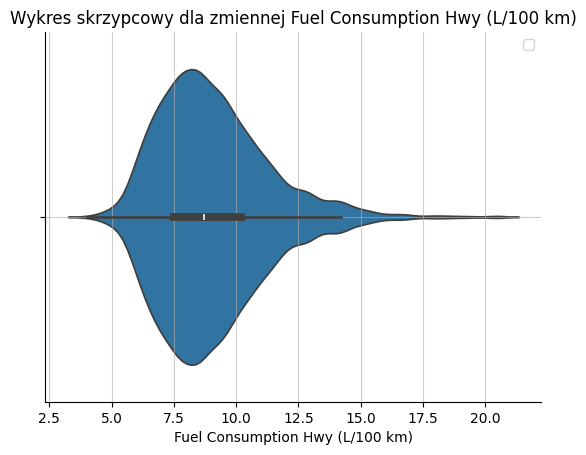

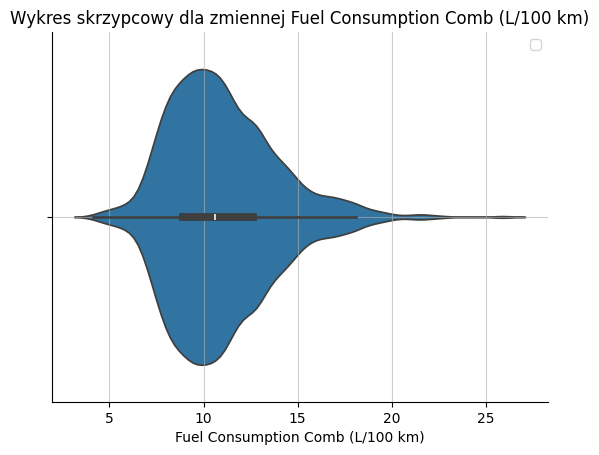

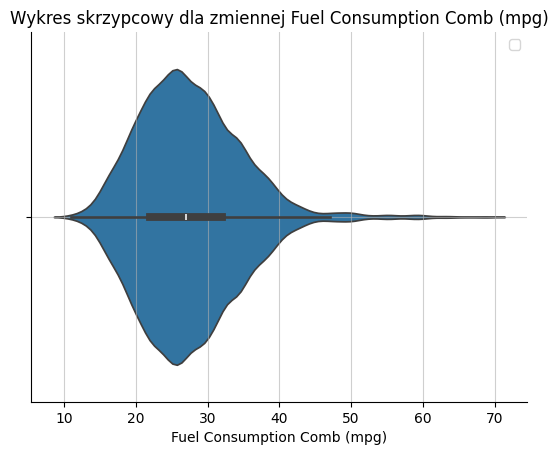

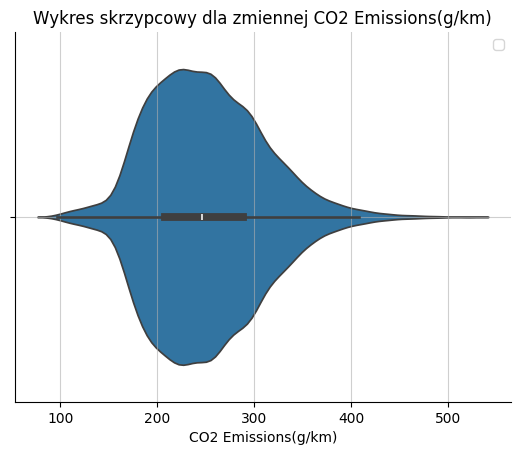

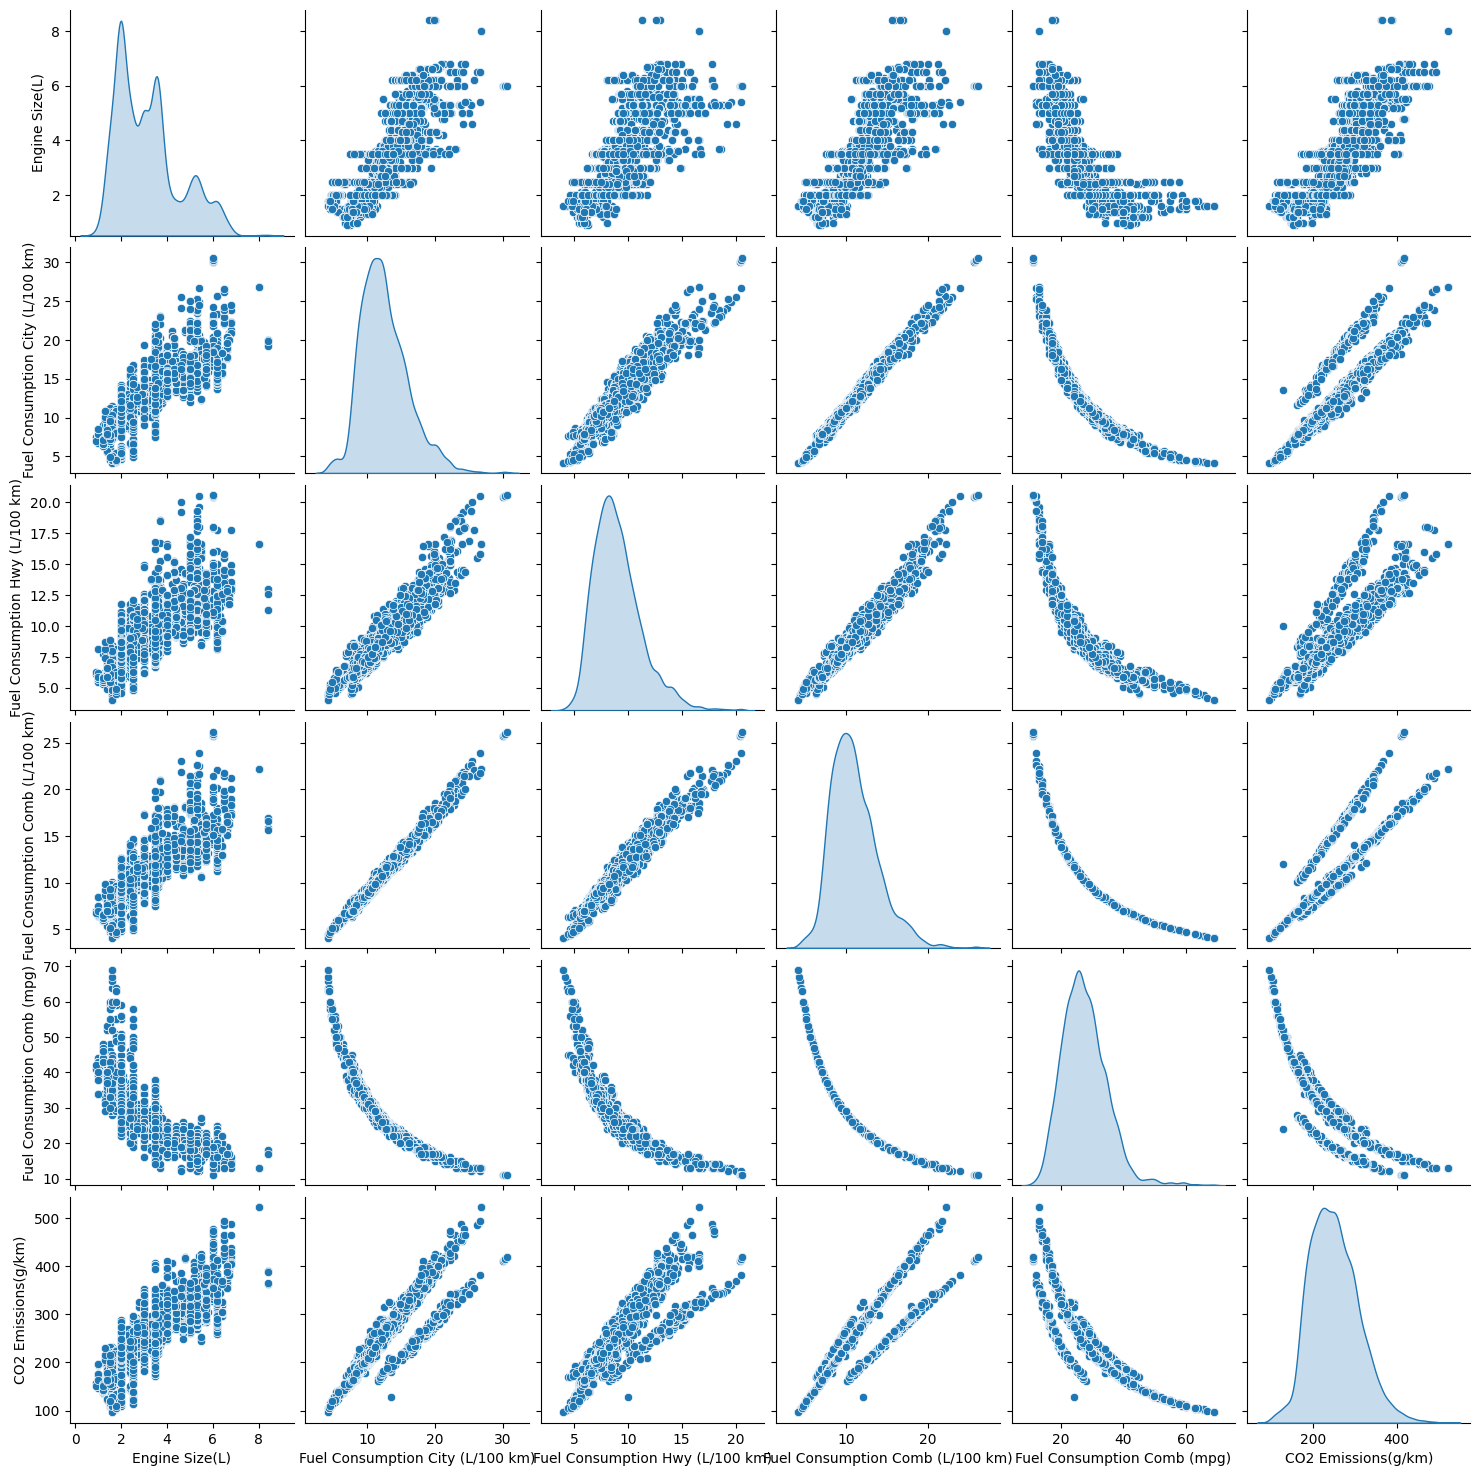

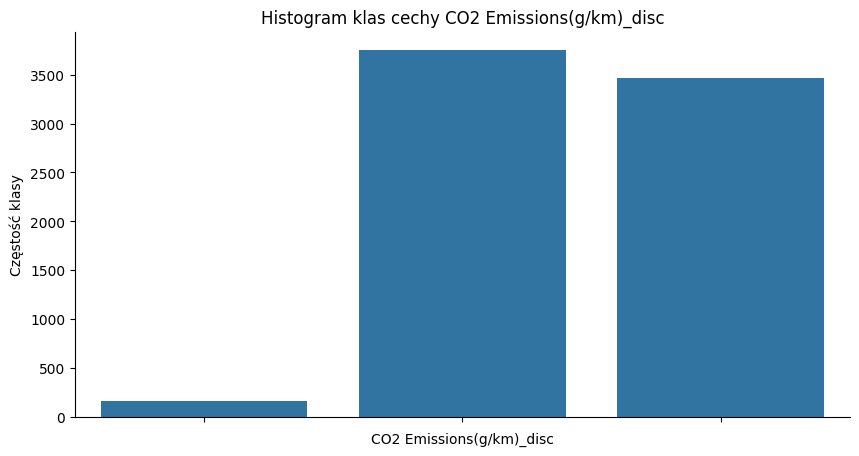

In [171]:
def ManualEmissionAnalysis(Filename:str, seperator:str, dec_sep: str, dtypes: dict[str, str], target_var:str, bins:list[float], n_splits:int, train_size :float, test_size:float) -> None:
    """Wielka analiza danych"""
    Dataset, n_rows = ReadDataFrame(Filename, seperator, dec_sep) #Odczytaj zestaw danych oraz liczbę wszystkich obserwacji.
    Features = Dataset.columns #Znajdź listę wszystkich cech w zbiorze danych.

    CatFeatures: list[str] = [feature for feature in Features if dtypes[feature] == "category"] #Cechy kategoryczne.
    FloatFeatures: list[str] = [feature for feature in Features if dtypes[feature] is np.float64] #Cechy ciągłe.


    # print("RYSOWANIE HISTOGRAMÓW DLA ZMIENNYCH KATEGORYCZNYCH")
    # #Agregacja rządkich klas dla zmiennych kategorycznych.
    # for CatFeature in CatFeatures:
    #     Histogram:pd.Series = CreateHistogram(Dataset = Dataset,  #Znajdź histogram unikatowych klas dla zmiennej CatFeature.
    #                                 CatFeature = CatFeature) 
        
    #     AggregateRarestClasses(Dataset, CatFeature, Histogram) #Zagreguj najrzadzsze klasy.

    #     Histogram_agg:pd.Series = CreateHistogram(Dataset = Dataset,  #Zagregowany histogram.
    #                                               CatFeature = CatFeature)
        
    #     PlotHistogram(Histogram_agg, CatFeature)

    
    #Kasowanie zbędnej obserwacji oraz quasi-id kolumny
    Dataset = DeleteFutileColsAndObs(Dataset)

    
    #print("RYSOWANIE MACIERZY KORELACJI DLA ZMIENNYCH NUMERYCZNYCH")
    #ComputeAndDrawCorrelationMatrix(Dataset, FloatFeatures)

    print("RYSOWANIE WYKRESÓW SKRZYPCOWYCH DLA Z MIENNYCH NUMERYCZNYCH")
    NarysujSkrzypce(Dataset, FloatFeatures)

    print("Rysowanie wykresu parowego dla zmiennych numerycznych")
    
    NarysujWykresParowy(Dataset, FloatFeatures)

    print("Dyskretyzacja zmiennej docelowej")
    #"Dyskretyzacja zmiennej docelowej"
    target_var_discr = target_var +"_disc"

    Discretize(Dataset, target_var, bins)

    Dataset.drop(columns = [target_var], inplace = True) #Porzuć starą, ciągłą zmienną celu.

    target_var_discr_histogram:pd.Series = CreateHistogram(Dataset, target_var_discr) #Znajdź histogram tabelkowy dla zdyskretyzowanej zmiennej celu.
    PlotHistogram(target_var_discr_histogram, target_var_discr) #Narysuj histogram dla zmiennej celu zdyskretyzowanej.

    
    Predictors = ['Make', "Vehicle Class",'Engine Size(L)','Cylinders','Transmission','Fuel Type',"Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)",
                                                                                   "Fuel Consumption Comb (L/100 km)","Fuel Consumption Comb (mpg)"]

    num_predictors = [feature for feature in Predictors if dtypes[feature] is np.float64]
    cat_predictors = [feature for feature in Predictors if dtypes[feature] == "category"]

            
        
ManualEmissionAnalysis("CO2Emission.csv", ';', ',', dtypes = dtypes, 
                       target_var = 'CO2 Emissions(g/km)', 
                       n_splits = 5, train_size = 0.8, test_size =0.2, bins = [150, 250])
        

Co dalej do roboty?:
2) Zamknięćie wszystkich funkcji w jedną, potężna funkcję.
4) Liczenie wskaźników dokładności, jeżeli selekcja cech była wybierana automatycznie.